# Universal Path Decomposition of Multilayer Transfer and Scattering Matrices


## Lattice Optimization Example

**Companion** to the homonymous paper by *Joaquin Garcia-Suarez* (2025)


This notebook provides an interactive implementation of the concepts introduced in the paper. The parameters are chosen to generate the results in Figure ??? of the main text. All computations are based on constant-mass assumption, units are normalized.


### Quantum Well Structure Initialization

This setup defines a **1D heterostructure** (e.g., GaAs/AlAs quantum wells) for simulating quantum resonances using transfer matrices.

---

### Key Parameters

- **Normalized constants**: $\hbar = m = 1$
- **Materials**:
  - GaAs: $V = 0.0$ eV (well)
  - AlAs: $V = 0.52$ eV (barrier)
- **Layers**:
  - `N = 7`: Must be odd to ensure symmetric well-barrier-well structure.
  - `h_list`: Alternating thicknesses (well = 3.0 nm, barrier = 1.5 nm)
  - `V_layers`: Alternating potential values

---

### Target

- **Resonance energy**: $E_{\text{res}} = 0.15$ eV

This setup is used to design or optimize quantum structures for a desired **resonant tunneling condition**.


In [1]:
import numpy as np
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
from itertools import combinations

# Constants (normalized units)
hbar = 1.0
m = 1.0  # effective mass

# Material potentials (eV)
V_GaAs = 0.0
V_AlAs = 0.52

# Desired number of layers (must be odd: well-barrier-well-...-well)
N = 7  

assert N % 2 == 1, "N must be odd (to start and end with a well)"

# Default thicknesses (in nm)
default_well = 3.0
default_barrier = 1.5

# Generate h_list
h_list = np.array([
    default_well if i % 2 == 0 else default_barrier
    for i in range(N)
])

V_GaAs = 0.0
V_AlAs = 0.52
V_layers = np.array([
    V_GaAs if i % 2 == 0 else V_AlAs
    for i in range(N)
])


# Resonance target energy (eV)
E_res = 0.15

# Compute Scattering Matrix using the Transfer Matrix Method (TMM)

### Transfer & Scattering Matrix Constructors

These functions support quantum transport calculations in 1D layered structures.

---

### `layer_T(k, h)`

- Returns the **$2 \times 2$ transfer matrix** of a homogeneous layer (thickness $h$, wavenumber $k$).
- Basis: $(\psi, \psi')$.
- Matrix form:

$$
T =
\begin{bmatrix}
\cos(kh) & \frac{\sin(kh)}{k} \\
-k \sin(kh) & \cos(kh)
\end{bmatrix}
$$

---

### `to_Smatrix(M, kL, kR)`

- Converts a transfer matrix $M$ into a **scattering matrix (Landauer form)** $S$.
- Assumes wavefunction derivative is *not normalized* by $\hbar/m$.
- Inputs:
  - `M`: $2 \times 2$ transfer matrix.
  - `kL`, `kR`: Wavenumbers in the left and right leads.

- Returns $S$ matrix:

$$
S =
\begin{bmatrix}
r & t' \\
t & r'
\end{bmatrix}
$$

- Where:
  - $r$, $r'$: Reflection coefficients (left/right)
  - $t$, $t'$: Transmission coefficients (left $\to$ right / right $\to$ left)

This is essential for extracting **observable quantities** like reflection and transmission probabilities from transfer matrix simulations.


In [2]:
def layer_T(k, h):
    """2×2 transfer matrix of a homogeneous slab (ψ, ψ') basis)."""
    c, s = np.cos(k*h), np.sin(k*h)
    return np.array([[ c,  s/k],
                     [-k*s, c   ]], dtype=complex)

def to_Smatrix(M, kL, kR):
    """
    Convert 2×2 transfer matrix (ψ,ψ') to 2×2 scattering matrix
    *without* the ħ/m normalisation of ψ'.
    kL, kR are the propagation wave-numbers in the left / right lead.
    """
    M11, M12, M21, M22 = M.ravel()

    # determinant appears only if masses or potentials differ in leads (not our case...)
    detM = M11*M22 - M12*M21

    denom =  M12*kL*kR - M21 + 1j*(M22*kL + M11*kR)

    r  = ( M12*kL*kR + M21 + 1j*(M22*kL - M11*kR) ) / denom
    t  = ( 2j*kL*detM ) / denom
    tP = ( 2j*kR*detM ) / ( M22*kL - M12*kL*kR*1j + M21*1j + M11*kR )
    rP = ( M12*kL*kR + M21 - 1j*(M22*kL - M11*kR) ) / (
          M12*kL*kR - M21 - 1j*(M22*kL + M11*kR) )

    return np.array([[r,  tP],
                     [t,  rP]], dtype=complex)

### Sanity Check (Energy Conservation in Quantum Transport)

The following block tests the **unitarity** (probability current conservation) of the quantum transport calculation through a multilayer structure.

---

### Process

1. **Energy Sweep**:
   - `E_list`: Energy values from 0.05 to 0.4 eV.

2. **Per-Energy Calculation**:
   - Compute wavenumbers in each region:  
     $$
     k_j = \sqrt{2m(E - V_j + i0^+)}
     $$
   - Build total **transfer matrix** `M_tot` by chaining layer matrices (left → right).
   - Extract wavenumbers in left and right leads: `kL`, `kR`.

3. **Convert to Scattering Matrix**:
   - Use `to_Smatrix(...)` to get transmission and reflection amplitudes.

4. **Compute Probabilities**:
   - $R = |r|^2$: reflection probability.
   - $T = |t|^2 \cdot \frac{k_R}{k_L}$: transmission probability with flux correction.

---

### Final Check

```python
print("Max|R+T-1| =", ...)
Must be machine-precision zero.


In [3]:
# Sanity Check---------------------------------------------------------
R, T = [], []
E_list = np.linspace(0.05, 0.4, 200)
for E in E_list:
    k_list = np.sqrt(2*m*(E - V_layers + 0j)) / hbar      # one k per region
    M_tot  = np.eye(2, dtype=complex)                     # cumulative T-matrix

    # chain left → right
    for k_i, h_i in zip(k_list, h_list):
        T_tot = layer_T(k_i, h_i) @ M_tot

    # leads are the first and last regions in this model
    kL, kR = k_list[0], k_list[-1]

    S = to_Smatrix(T_tot, kL, kR)

    r_amp, t_amp = S[0,0], S[1,0]

    R.append(np.abs(r_amp)**2)
    T.append(np.abs(t_amp)**2 * kR.real / kL.real)        # flux factor

print("Max|R+T-1| =", np.max(np.abs(np.asarray(R) + np.asarray(T) - 1)))

Max|R+T-1| = 8.881784197001252e-16


# Compute Scattering Matrix using the Path Decomposition

### `compute_S_path_entries(...)`

Computes the **scattering matrix elements** $(S_{11}, S_{12}, S_{21}, S_{22})$ for a multilayer potential using **path decomposition**, where each path accounts for a specific sequence of internal reflections.

---

### Parameters

- `E_list`: Array of energies (eV).
- `V`: Layer potential profile, shape $(N,)$.
- `l`: Layer thicknesses, shape $(N,)$.
- `paths_array`: Array of ±1-valued paths, shape $(P, N)$.
- `m`, `hbar`: Particle mass and reduced Planck constant (default: 1.0, natural units).

---

### Method

For each energy $E$:

1. **Compute Wavenumbers**:
   - $k_j = \sqrt{2m(E - V_j)} / \hbar$ (complex to handle tunneling).
   - Define interface ratios:
     $$
     r_j = \frac{k_j}{k_{j+1}}, \quad r_j^{-1} = \frac{k_{j+1}}{k_j}
     $$

2. **For Each Path `p`**:
   - Define adjacent elements:
     - $e_1 = p[:-1]$, $e_2 = p[1:]$, $e_N = p[-1]$
   - Compute:
     - $A = \prod_j \frac{1 + e_1 e_2 r_j}{2}$  
     - $A' = \prod_j \frac{1 + e_1 e_2 r_j^{-1}}{2}$
   - Form:
     $$
     A_+  = \frac{1}{2} \left(A + A' \cdot \frac{k_1}{k_N}\right), \quad
     A_-  = \frac{1}{2} \left(A - A' \cdot \frac{k_1}{k_N}\right)
     $$
   - Compute phase:
     $$
     \phi = \sum_j p_j k_j l_j, \quad \text{then} \quad e^{\pm i e_N \phi}
     $$
   - Accumulate:
     $$
     S_{11} += A_+ \cdot e^{-i e_N \phi}, \quad
     S_{12} += A_- \cdot e^{-i e_N \phi}
     $$
     $$
     S_{21} += A_- \cdot e^{+i e_N \phi}, \quad
     S_{22} += A_+ \cdot e^{+i e_N \phi}
     $$

3. **Store Results**:
   - For each energy, append $(S_{11}, S_{12}, S_{21}, S_{22})$.

---

### Returns

- Tuple of 4 arrays: $(S_{11}, S_{12}, S_{21}, S_{22})$, each of shape $(F,)$.

---

### Notes

- Could be truncated (e.g., with max reflection count) for efficiency while retaining accuracy at lower frequencies (see seismology example).


In [4]:
def compute_S_path_entries(E_list, V, l, paths_array, m=1.0, hbar=1.0):
    """
    Compute S_{11}, S_{12}, S_{21}, S_{22} via path decomposition for a list of energies.

    Parameters
    ----------
    E_list : array-like
        Energies at which to evaluate the scattering matrix entries.
    V : ndarray
        Layer potential profile, shape (N,)
    l : ndarray
        Layer thicknesses, shape (N,)
    paths_array : ndarray
        Array of shape (P, N), with paths defined using ±1 entries.
    m, hbar : float
        Mass and Planck's constant (can be set to 1 in atomic units).

    Returns
    -------
    S11_vals, S12_vals, S21_vals, S22_vals : complex arrays of shape (F,)
    """
    S11_vals, S12_vals, S21_vals, S22_vals = [], [], [], []

    for E in E_list:
        k = np.sqrt(2 * m * (E - V + 0j)) / hbar
        k_ratios     = k[:-1] / k[1:]
        k_ratios_inv = k[1:] / k[:-1]
        k1, kN = k[0], k[-1]

        S11_sum = 0
        S12_sum = 0
        S21_sum = 0
        S22_sum = 0

        for p in paths_array:
            e1, e2 = p[:-1], p[1:]
            eN = p[-1]

            # Compute amplitudes
            A      = np.prod(0.5 * (1 + e1 * e2 * k_ratios))
            A_prime= np.prod(0.5 * (1 + e1 * e2 * k_ratios_inv))

            A_plus  = (A + A_prime * k1 / kN) / 2
            A_minus = (A - A_prime * k1 / kN) / 2

            phi = np.sum(p * k * l)
            exp_iphi  = np.exp(+1j * eN * phi)
            exp_inphi = np.exp(-1j * eN * phi)

            # Accumulate contributions
            S11_sum += A_plus  * exp_inphi
            S12_sum += A_minus * exp_inphi
            S21_sum += A_minus * exp_iphi
            S22_sum += A_plus  * exp_iphi

        S11_vals.append(S11_sum)
        S12_vals.append(S12_sum)
        S21_vals.append(S21_sum)
        S22_vals.append(S22_sum)

    return (np.array(S11_vals), np.array(S12_vals),
            np.array(S21_vals), np.array(S22_vals))


### `generate_paths(N)`

Generates all possible **paths** through an $N$-layer system.

---

### How It Works

- `positions = range(1, N)`: Defines possible combinations.
- For each number of flips $r$ (from 0 to $N-1$):
  - Enumerates all combinations of $r$ flip positions.
  - Initializes a path of ones: $[+1, +1, \dots, +1]$.
  - Flips the sign at each selected position and all subsequent entries.
- Each path represents a possible sequence of direction changes across layers (e.g., partial reflections).

---

### Output

- Returns a NumPy array `paths_array` of shape $(2^{N-1}, N)$.
- Each row is a unique ±1 path vector.

In [5]:
def generate_paths(N):
    paths = []
    positions = list(range(1, N))
    for r in range(N):
        for flips in combinations(positions, r):
            p = np.ones(N, dtype=int)
            sign = 1
            for i in range(1, N):
                if i in flips:
                    sign *= -1
                p[i] = sign
            paths.append(p)
    return np.array(paths)

Use the two prior functions:

In [6]:
paths_array = generate_paths(N)

S11_path_vals, S12_path_vals, S21_path_vals, S22_path_vals = compute_S_path_entries(
    E_list, V_layers, h_list, paths_array, m, hbar
)

### `to_lb(S, kL, kR)`: Scattering Matrix to Landabauer basis

This function transforms a **scattering matrix** $S$ from the standard symmetric basis into a consistent representation.

---

### Parameters

- `S`: $2 \times 2$ scattering matrix from change of basis of $T$.
- `kL`, `kR`: Wavenumbers in the left and right leads (not used in this example as the material is the same at both ends).


In [7]:
def to_lb(S, kL, kR):
    S11, S12, S21, S22 = S.ravel()
    r  = - S21 / S22
    t  =   S11 - (S12 * S21) / S22
    tP =   1.0 / S22            # “t prime”: right → left
    rP =   S12 / S22            # 
    return np.array([[r,  tP],
                     [t,  rP]], dtype=complex)

### Repeat the Sanity Check (Energy Conservation in Quantum Transport)

The following block tests the **unitarity** (probability current conservation), this time using the path-derived results.

In [8]:
R_paths, T_paths = [], []

for i, E in enumerate(E_list):  # loop with index i
    k_layers = np.sqrt(2 * m * (E - V_layers + 0j)) / hbar
    kL, kR = k_layers[0], k_layers[-1]
    
    S_paths = np.array([
        [S11_path_vals[i], S12_path_vals[i]],
        [S21_path_vals[i], S22_path_vals[i]]
    ], dtype=complex)

    S_lb = to_lb(S_paths, kL, kR)  # Use index i to access S_paths

    r_amp, t_amp = S_lb[0, 0], S_lb[1, 0]
    R_paths.append(np.abs(r_amp)**2)
    T_paths.append(np.abs(t_amp)**2 * kR.real / kL.real)  # flux conservation

print("max |R+T-1| =", np.max(np.abs(np.array(R_paths) + np.array(T_paths) - 1)))


max |R+T-1| = 7.993605777301127e-15


### Visual verification
In order to make sure that both methods deliver the same result

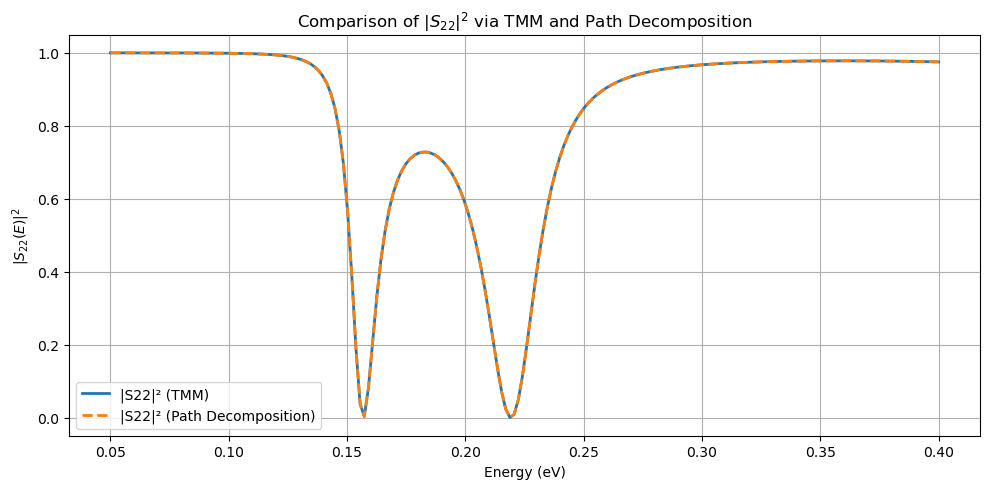

In [9]:
# Setup arrays
S22_modsq_TMM = []
S22_modsq_paths = []

# Loop over energies
for i, E in enumerate(E_list):
    # Wavenumbers
    k_list = np.sqrt(2 * m * (E - V_layers + 0j)) / hbar
    kL, kR = k_list[0], k_list[-1]

    # --- 1. Transfer Matrix → Scattering Matrix
    M_tot = np.eye(2, dtype=complex)
    for k_i, h_i in zip(k_list, h_list):
        M_tot = layer_T(k_i, h_i) @ M_tot

    S_TMM = to_Smatrix(M_tot, kL, kR)
    S22_TMM = S_TMM[1, 1]
    S22_modsq_TMM.append(np.abs(S22_TMM)**2)

    # --- 2. Path decomposition → S22
    S_paths = np.array([
        [S11_path_vals[i], S12_path_vals[i]],
        [S21_path_vals[i], S22_path_vals[i]]
    ], dtype=complex)
    
    S_lb = to_lb(S_paths, kL, kR)
    
    S22_path = S_lb[1, 1]
    S22_modsq_paths.append(np.abs(S22_path)**2)

plt.figure(figsize=(10, 5))
plt.plot(E_list, S22_modsq_TMM, label='|S22|² (TMM)', linewidth=2)
plt.plot(E_list, S22_modsq_paths, '--', label='|S22|² (Path Decomposition)', linewidth=2)
plt.xlabel('Energy (eV)')
plt.ylabel(r'$|S_{22}(E)|^2$')
plt.title('Comparison of $|S_{22}|^2$ via TMM and Path Decomposition')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Global Optimization Problem

**Goal**: Find layer thicknesses `h_trial` that maximize **transmission** at a target resonance energy $E_{\text{res}} = 0.15$ eV.

- **Design variables**: Layer thicknesses (alternating GaAs/AlAs).
- **Objective**: Minimize squared penalty if transmission $T < 0.95$ at $E_{\text{res}}$ using a **global** method (differential_evolution).
---


### Auxiliary Function: `evaluate_transmission(...)`

Computes the **transmission spectrum** $T(E)$ for a given set of layer thicknesses.

---

### Inputs
- `h_list`: List of layer thicknesses (nm).
- `E_list`: List of energies (eV) to evaluate transmission at.

---

### Output
- `T_vals`: NumPy array of transmission values corresponding to `E_list`.

In [10]:
def evaluate_transmission(h_list, E_list):
    V = np.array([V_GaAs if i % 2 == 0 else V_AlAs for i in range(len(h_list))])
    T_vals = []

    for E in E_list:
        k_list = np.sqrt(2 * m * (E - V + 0j)) / hbar
        M_tot = np.eye(2, dtype=complex)
        for k_i, h_i in zip(k_list, h_list):
            M_tot = layer_T(k_i, h_i) @ M_tot
        S = to_Smatrix(M_tot, k_list[0], k_list[-1])
        t_amp = S[1, 0]
        T = np.abs(t_amp)**2 * k_list[-1].real / k_list[0].real
        T_vals.append(T)

    return np.array(T_vals)

---
### Auxiliary Function: `objective(h_trial)`

Defines the **objective function** for optimizing quantum well/barrier **thicknesses**.

---

### Mechanism

- Computes wavenumbers and builds the full **transfer matrix**.
- Converts to **scattering matrix** to extract transmission amplitude.
- Computes transmission probability $T$.
- Returns a **penalized loss** if $T < 0.95$, encouraging solutions with near-unity transmission.

---

### Use

This function is used as the target for optimization (with `scipy.optimize.differential_evolution`) to find layer thicknesses that create a **resonance** at $E_{\text{res}}$.

In [11]:
def objective(h_trial):
    k_list = np.sqrt(2 * m * (E_res - V_layers + 0j)) / hbar

    # Build full transfer matrix
    T_tot = np.eye(2, dtype=complex)
    for k_i, h_i in zip(k_list, h_trial):
        T_tot = layer_T(k_i, h_i) @ T_tot

    S = to_Smatrix(T_tot, k_list[0], k_list[-1])
    t_amp = S[1, 0]
    T = np.abs(t_amp)**2 

    return (max(0, 0.95 - T))**2  # Penalize if below 0.95


Use the function:

In [12]:
bounds = [(1.0, 5.0) if i % 2 == 0 else (1.0, 3.0) for i in range(N)]  # wells/barriers
result = differential_evolution(objective, bounds, popsize=10, maxiter=40, disp=True, polish=False)

optimal_h_TMM = result.x

differential_evolution step 1: f(x)= 0.0323449
differential_evolution step 2: f(x)= 0.0102788
differential_evolution step 3: f(x)= 0.0102788
differential_evolution step 4: f(x)= 0
differential_evolution step 5: f(x)= 0
differential_evolution step 6: f(x)= 0
differential_evolution step 7: f(x)= 0
differential_evolution step 8: f(x)= 0
differential_evolution step 9: f(x)= 0
differential_evolution step 10: f(x)= 0
differential_evolution step 11: f(x)= 0
differential_evolution step 12: f(x)= 0
differential_evolution step 13: f(x)= 0
differential_evolution step 14: f(x)= 0
differential_evolution step 15: f(x)= 0
differential_evolution step 16: f(x)= 0
differential_evolution step 17: f(x)= 0
differential_evolution step 18: f(x)= 0
differential_evolution step 19: f(x)= 0
differential_evolution step 20: f(x)= 0
differential_evolution step 21: f(x)= 0
differential_evolution step 22: f(x)= 0
differential_evolution step 23: f(x)= 0
differential_evolution step 24: f(x)= 0
differential_evolution st

### Auxiliary Function: `objective_from_paths(h_trial)`

Defines an **alternative objective function** using **path decomposition** instead of the full transfer matrix.


---

### Method

- Computes wave numbers and interface ratios once.
- For each path in `paths_array`:
  - Computes transmission amplitude contribution based on phase and interface products.
- Sums contributions to estimate $S_{22}$, then computes:
  $$
  T = \left| \frac{1}{S_{22}} \right|^2
  $$
- Penalizes if $T < 0.95$.

In [13]:
def objective_from_paths(h_trial):
    """
    Compute objective using path-based decomposition
    for given layer thicknesses h_trial.
    """
    k = np.sqrt(2 * m * (E_res - V_layers + 0j)) / hbar  # (N,)
    

    k_ratios     = k[:-1] / k[1:]
    k_ratios_inv = k[1:] / k[:-1]
    k1, kN = k[0], k[-1]

    S11_sum = 0
    S12_sum = 0
    S21_sum = 0
    S22_sum = 0

    for p in paths_array:
        e1, e2 = p[:-1], p[1:]
        eN = p[-1]

        # Compute amplitudes
        A      = np.prod(0.5 * (1 + e1 * e2 * k_ratios))
        A_prime= np.prod(0.5 * (1 + e1 * e2 * k_ratios_inv))

        A_plus  = (A + A_prime * k1 / kN) / 2
        A_minus = (A - A_prime * k1 / kN) / 2

        phi = np.sum(p * k * h_trial)
        exp_iphi  = np.exp(+1j * eN * phi)
        exp_inphi = np.exp(-1j * eN * phi)

        # Accumulate contributions
        S11_sum += A_plus  * exp_inphi
        S12_sum += A_minus * exp_inphi
        S21_sum += A_minus * exp_iphi
        S22_sum += A_plus  * exp_iphi

         
    
    t_amp = 1 / S22_sum
    T_val = np.abs(t_amp)**2

    return (max(0, 0.95 - T_val))**2

In [14]:
bounds = [(1.0, 5.0) if i % 2 == 0 else (1.0, 3.0) for i in range(N)]  # wells/barriers


# Note that the path decomposition is evaluated within a GLOBAL optimization 
result = differential_evolution(
    objective_from_paths,
    bounds=bounds,
    popsize=20,
    maxiter=40,
    disp=True,
    polish=False
)

optimal_h_paths = result.x

differential_evolution step 1: f(x)= 0
differential_evolution step 2: f(x)= 0
differential_evolution step 3: f(x)= 0
differential_evolution step 4: f(x)= 0
differential_evolution step 5: f(x)= 0
differential_evolution step 6: f(x)= 0
differential_evolution step 7: f(x)= 0
differential_evolution step 8: f(x)= 0
differential_evolution step 9: f(x)= 0
differential_evolution step 10: f(x)= 0
differential_evolution step 11: f(x)= 0
differential_evolution step 12: f(x)= 0
differential_evolution step 13: f(x)= 0
differential_evolution step 14: f(x)= 0
differential_evolution step 15: f(x)= 0
differential_evolution step 16: f(x)= 0
differential_evolution step 17: f(x)= 0
differential_evolution step 18: f(x)= 0
differential_evolution step 19: f(x)= 0
differential_evolution step 20: f(x)= 0
differential_evolution step 21: f(x)= 0
differential_evolution step 22: f(x)= 0
differential_evolution step 23: f(x)= 0
differential_evolution step 24: f(x)= 0
differential_evolution step 25: f(x)= 0
different

In [15]:
print("Optimized thicknesses [nm] (TMM):", optimal_h_TMM)
print("Optimized thicknesses [nm] (Paths):", optimal_h_paths)

Optimized thicknesses [nm] (TMM): [2.27899166 1.03648099 3.93993199 1.91533574 3.77846227 1.55887683
 1.4342381 ]
Optimized thicknesses [nm] (Paths): [4.6788729  1.17165502 4.00628682 1.18639101 4.07920676 1.00241042
 2.81978823]


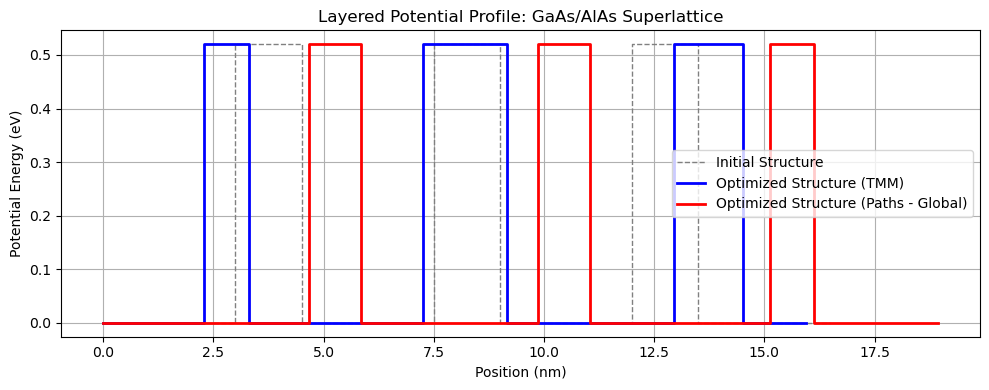

In [16]:
def build_potential_profile(h_list, V_list):
    """Return piecewise positions and potentials for plotting."""
    z = [0]
    V_plot = []
    for h, V in zip(h_list, V_list):
        z.append(z[-1] + h)
        V_plot.extend([V, V])
    z = np.repeat(z, 2)[1:-1]  # ensure steps at interfaces
    return z, V_plot


# Original potentials
z_initial, V_plot_initial = build_potential_profile(h_list, V_layers)

# Optimized potentials
z_opt, V_plot_opt = build_potential_profile(optimal_h_TMM, V_layers)

# Optimized potentials (from path evaluation PE)
z_opt_PE, V_plot_opt_PE = build_potential_profile(optimal_h_paths, V_layers)

# Plot
plt.figure(figsize=(10, 4))
plt.step(z_initial, V_plot_initial, 'gray', label='Initial Structure', linestyle='--', linewidth=1)
plt.step(z_opt, V_plot_opt, 'blue' , label='Optimized Structure (TMM)', linestyle='-', linewidth=2)
plt.step(z_opt_PE, V_plot_opt_PE, 'red', label='Optimized Structure (Paths - Global)', linestyle='-', linewidth=2)
plt.xlabel('Position (nm)')
plt.ylabel('Potential Energy (eV)')
plt.title('Layered Potential Profile: GaAs/AlAs Superlattice')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


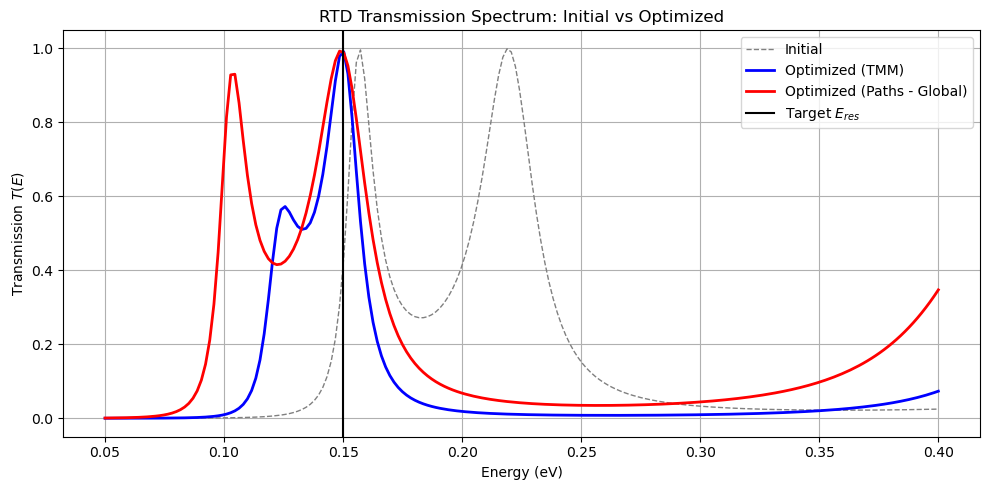

In [17]:
T_initial = evaluate_transmission(h_list, E_list)
T_optimized = evaluate_transmission(optimal_h_TMM, E_list)
T_optimized_PG = evaluate_transmission(optimal_h_paths, E_list)

plt.figure(figsize=(10, 5))
plt.plot(E_list, T_initial, 'gray', label='Initial',linestyle='--', linewidth=1)
plt.plot(E_list, T_optimized, 'blue', label='Optimized (TMM)', linewidth=2)
plt.plot(E_list, T_optimized_PG, 'red', label='Optimized (Paths - Global)', linewidth=2)
plt.axvline(E_res, color='black', linestyle='-', label='Target $E_{res}$')
plt.xlabel('Energy (eV)')
plt.ylabel('Transmission $T(E)$')
plt.title('RTD Transmission Spectrum: Initial vs Optimized')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Local Optimization Problem

**Goal**: same as global optimization (find layer thicknesses `h_trial` that maximize transmission at$E_{\text{res}} = 0.15$ eV) but now carried out with a local gradient-based method (L-BFGS-B) thanks to the closed-form results derived from paths.


--- 

### Auxiliary Function: `loss_only_from_paths(h_trial)`

Computes a **scalar loss** based on path decomposition, suitable for use in optimization routines (e.g., with numerical gradients).

---

### Key Features

- Evaluates scattering amplitudes from finite path contributions (`paths_array`).
- Computes $T = |1 / S_{22}|^2$ to estimate transmission.
- Returns squared penalty if $T < 0.95$.

---

### Use Case

- Suitable for optimization when **analytical gradients are not available**.
- Designed for **fast, differentiable surrogate modeling** of resonant tunneling structures.


In [18]:
def loss_only_from_paths(h_trial):
    """
    Compute objective using path decomposition (gradient computed with finite differences for now).
    """
    k = np.sqrt(2 * m * (E_res - V_layers + 0j)) / hbar

    k_ratios     = k[:-1] / k[1:]
    k_ratios_inv = k[1:]  / k[:-1]
    k1, kN = k[0], k[-1]

    S11_sum = 0
    S12_sum = 0
    S21_sum = 0
    S22_sum = 0

    for p in paths_array:
        e1, e2 = p[:-1], p[1:]
        eN = p[-1]

        A      = np.prod(0.5 * (1 + e1 * e2 * k_ratios))
        A_prime= np.prod(0.5 * (1 + e1 * e2 * k_ratios_inv))

        A_plus  = (A + A_prime * k1 / kN) / 2
        A_minus = (A - A_prime * k1 / kN) / 2

        phi = np.sum(p * k * h_trial)
        exp_iphi  = np.exp(+1j * eN * phi)
        exp_inphi = np.exp(-1j * eN * phi)

        S11_sum += A_plus  * exp_inphi
        S12_sum += A_minus * exp_inphi
        S21_sum += A_minus * exp_iphi
        S22_sum += A_plus  * exp_iphi

    t_amp = 1 / S22_sum
    T_val = np.abs(t_amp)**2

    return float((max(0, 0.95 - T_val))**2)


In [19]:
from scipy.optimize import minimize

# Bounds (e.g., well: 1–5 nm, barrier: 1–3 nm)
bounds = [(1.0, 5.0) if i % 2 == 0 else (1.0, 3.0) for i in range(N)]

# Run L-BFGS-B with numerical finite-difference gradient
result = minimize(
    fun     = loss_only_from_paths,
    x0      = h_list,                    # initial guess
    method  = 'L-BFGS-B',
    jac     = False,                     # finite differences
    bounds  = bounds,
    options = dict(disp=True, maxiter=100)
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.87724D-01    |proj g|=  2.00000D+00

At iterate    1    f=  3.15511D-02    |proj g|=  7.61525D-01

At iterate    2    f=  0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      2      5      7     0     0   0.000D+00   0.000D+00
  F =   0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [20]:
optimal_h_PL = result.x
print("Optimized thicknesses [nm]:", optimal_h_PL)


Optimized thicknesses [nm]: [3.00000002 1.45557471 3.13854441 1.46820371 3.13854441 1.4555747
 2.99999998]


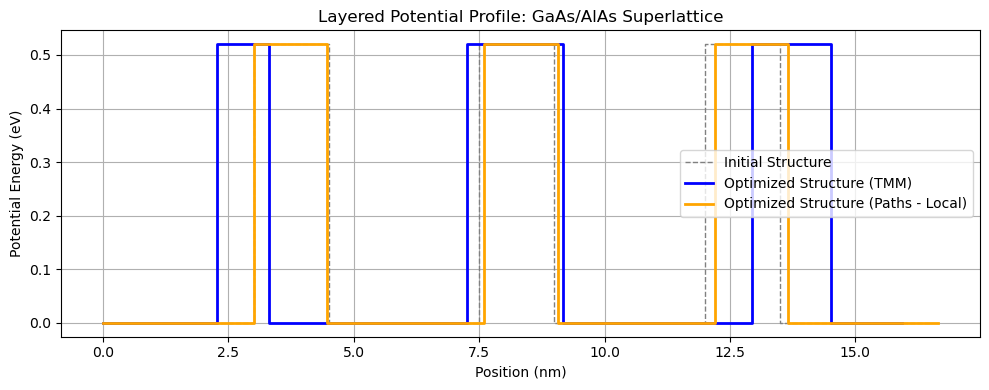

In [21]:
# Optimized potentials (from path analytical PA)
z_opt_PL, V_plot_opt_PL = build_potential_profile(optimal_h_PL, V_layers)

# Plot
plt.figure(figsize=(10, 4))
plt.step(z_initial, V_plot_initial, 'gray', label='Initial Structure', linestyle='--', linewidth=1)
plt.step(z_opt, V_plot_opt, 'blue' , label='Optimized Structure (TMM)', linestyle='-', linewidth=2)
plt.step(z_opt_PL, V_plot_opt_PL, 'orange', label='Optimized Structure (Paths - Local)', linestyle='-', linewidth=2)
plt.xlabel('Position (nm)')
plt.ylabel('Potential Energy (eV)')
plt.title('Layered Potential Profile: GaAs/AlAs Superlattice')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


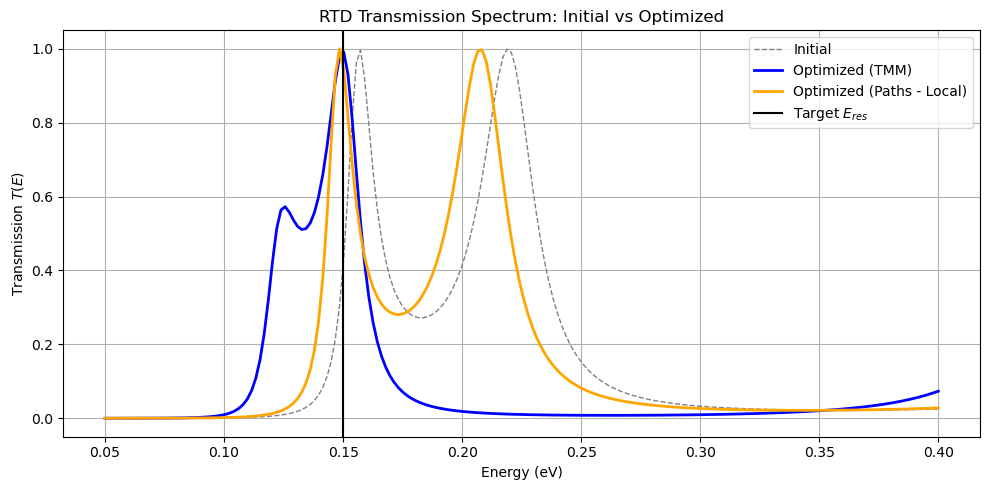

In [22]:
T_optimized_PL = evaluate_transmission(optimal_h_PL, E_list)

plt.figure(figsize=(10, 5))
plt.plot(E_list, T_initial, 'gray', label='Initial',linestyle='--', linewidth=1)
plt.plot(E_list, T_optimized, 'blue', label='Optimized (TMM)', linewidth=2)
plt.plot(E_list, T_optimized_PL, 'orange', label='Optimized (Paths - Local)', linewidth=2)
plt.axvline(E_res, color='black', linestyle='-', label='Target $E_{res}$')
plt.xlabel('Energy (eV)')
plt.ylabel('Transmission $T(E)$')
plt.title('RTD Transmission Spectrum: Initial vs Optimized')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

---
### Conclusions

- **Path decomposition** provides a flexible alternative to the Transfer Matrix Method (TMM) for modeling quantum transport.
- Unlike TMM, which is inherently non-differentiable and sensitive to numerical instabilities, **path-based models**:
  - Work well with **global optimization** (e.g., differential evolution),
  - Can also be applied in **local optimization** frameworks using finite-difference gradients.

---

### Future Work

- Extend the method by incorporating **analytical gradients** for path decomposition.
- Challenge: deriving stable gradients seems to require **careful conditioning**.
- Potential benefits:
  - Faster convergence in optimization,
  - Better scalability to high-dimensional design spaces.
